# Load libraries

In [39]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]
from glob import glob
import os
from copy import deepcopy

import numpy as np
import cv2
from PIL import Image

import torch
from torch.utils.data import Dataset
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torchvision.transforms import v2, functional
from torchvision import transforms
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io


from urllib.request import urlretrieve

# Lorenz's libs
# import math
import pandas as pd
import requests
from io import BytesIO
# from pyproj import Proj, Transformer
import random
# from tqdm import tqdm
# import folium
# from folium.plugins import MarkerCluster

# Define helper functions/classes

In [40]:
## convert RGB to the personal LAB (LAB2)
# the input R,G,B,  must be 1D from 0 to 255
# the outputs are 1D  L [0 1], a [-1 1] b [-1 1]
def RGB2LAB2(R0, G0, B0):

    R=R0/255
    G=G0/255
    B=B0/255

    # Y=0.3*R + 0.59*G + 0.11*B
    # X=0.45*R + 0.35*G + 0.2*B
    # Z=0.01*R + 0.09*G + 0.9*B

    Y=0.299*R + 0.587*G + 0.114*B
    X=0.449*R + 0.353*G + 0.198*B
    Z=0.012*R + 0.089*G + 0.899*B

    # X - Y = 0.150*R - 0.234*G + 0.084*B  = a0
    # Y - Z = 0.287*R + 0.498*G - 0.785*B  = b0

    L = Y
    a = (X - Y)/0.234
    b = (Y - Z)/0.785

    return L, a, b

## convert the personal LAB (LAB2)to the RGB
# the input L,a,b,  must be 1D L [0 1], a [-1 1] b [-1 1]
# the outputs are 1D  R g B [0 255]
def LAB22RGB(L, a, b):

    a11 = 0.299
    a12 = 0.587
    a13 = 0.114
    a21 = (0.15/0.234)
    a22 = (-0.234/0.234)
    a23 = (0.084/0.234)
    a31 = (0.287/0.785)
    a32 = (0.498/0.785)
    a33 = (-0.785/0.785)

    aa=np.array([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
    C0=np.zeros((L.shape[0],3))
    C0[:,0]=L[:,0]
    C0[:,1]=a[:,0]
    C0[:,2]=b[:,0]
    C = np.transpose(C0)
    # C = np.array([L, a, b])
    # print(C.shape)
    # print(L.shape)
    # print(a.shape)
    # print(b.shape)
    # print(aa.shape)

    X = np.linalg.inv(aa).dot(C)
    X1D=np.reshape(X,(X.shape[0]*X.shape[1],1))
    p0=np.where(X1D<0)
    X1D[p0[0]]=0
    p1=np.where(X1D>1)
    X1D[p1[0]]=1
    Xr=np.reshape(X1D,(X.shape[0],X.shape[1]))

    Rr = Xr[0][:]
    Gr = Xr[1][:]
    Br = Xr[2][:]

    R = np.uint(np.round(Rr*255))
    G = np.uint(np.round(Gr*255))
    B = np.uint(np.round(Br*255))
    # p0=np.where(L<0.02)
    # R[p0[0]]=0
    # G[p0[0]]=0
    # B[p0[0]]=0
    # p1=np.where(L>0.98)
    # R[p1[0]]=255
    # G[p1[0]]=255
    # B[p1[0]]=255
    return R, G, B



def convert_RGB_to_feed_model(img):
    img = np.asarray(img)
    sz_x = img.shape[0]
    sz_y = img.shape[1]

    train_imgs = np.zeros((sz_x, sz_y, 2))
    train_input = np.zeros((sz_x, sz_y, 1))

    R1 = np.reshape(img[:, :, 0], (sz_x * sz_y, 1))
    G1 = np.reshape(img[:, :, 1], (sz_x * sz_y, 1))
    B1 = np.reshape(img[:, :, 2], (sz_x * sz_y, 1))
    L, A, B = RGB2LAB2(R1, G1, B1)

    train_input[:, :, 0] = L.reshape((sz_x, sz_y))
    train_imgs[:, :, 0] = np.reshape(A, (sz_x, sz_y))
    train_imgs[:, :, 1] = np.reshape(B, (sz_x, sz_y))

    return train_input, train_imgs

In [41]:
def plot_transform(orig_img, imgs, with_orig=True, row_title=None, img_size = 10, **imshow_kwargs):

    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False, figsize = (img_size, img_size))
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

# Define custom Dataset class


In [42]:
class SwisstopoDataset:
    def __init__(self, img_indx, transform=None, large_dataset=False, return_label=True, batch_size=32, shuffle=False):
        self.img_indx = img_indx
        self.transform = transform
        self.large_dataset = large_dataset
        self.return_label = return_label
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Set the appropriate port based on the dataset size
        self.port = 1986 if self.large_dataset else 1985

        # Load metadata
        self.metadata_file = self._load_metadata()

    def _load_metadata(self):
        raw_data_csv_file_link = f"https://perritos.myasustor.com:{self.port}/metadata.csv"
        return pd.read_csv(raw_data_csv_file_link, index_col=0)

    def _fetch_image(self, img_id):
        img_in_server_link = f"https://perritos.myasustor.com:{self.port}/data/img_id_{img_id}.jpg"
        response = requests.get(img_in_server_link)
        image = Image.open(BytesIO(response.content))
        return image

    def _process_image(self, img_id):
        image = self._fetch_image(img_id)
        if self.transform is not None:
            image = self.transform(image)
        else:
            image = tf.keras.preprocessing.image.img_to_array(image)
            image = image / 255.0  # Default normalization
        return image

    def _get_label(self, idx):
        return self.metadata_file["class"].iloc[idx]

    def _generator(self):
        if self.shuffle:
            img_indices = np.random.permutation(len(self.img_indx))
        else:
            img_indices = self.img_indx

        for idx in range(len(self.img_indx)):
            image = self._process_image(self.img_indx[idx])
            L, AB = image  # Unpack the transformed image
            if self.return_label:
                label = self._get_label(idx)
                yield (L, AB), label
            else:
                yield L, AB

    def get_dataset(self):
        # Dynamically infer the shapes of L and AB channels
        def _dynamic_output_signature():
            example_image = self._fetch_image(self.img_indx[0])
            example_transformed = self.transform(example_image)
            L, AB = example_transformed
            L_shape = tf.TensorSpec(shape=L.shape, dtype=tf.float32)
            AB_shape = tf.TensorSpec(shape=AB.shape, dtype=tf.float32)
            if self.return_label:
                return ((L_shape, AB_shape), tf.TensorSpec(shape=(), dtype=tf.int64))
            else:
                return (L_shape, AB_shape)

        output_signature = _dynamic_output_signature()

        dataset = tf.data.Dataset.from_generator(self._generator, output_signature=output_signature)
        dataset = dataset.batch(self.batch_size)
        return dataset

# Define transforms


In [43]:
def convert_to_LAB_transform(image):
    L, AB = convert_RGB_to_feed_model(image)
    return (L, AB)

# Check info from the images

The data was initially created using the scripts `retrieve_data.ipynb` and stored in a private server for later (re)use.
In the metadata.csv file we get the information on original link, class and coordinates of each image.

NOTE: the following are links stored in a private server, jet they are still publically available.

In [44]:
is_large_dataset = True

if is_large_dataset:
    server_port = 1986 # Large dataset of ~10K images
else:
    server_port = 1985 # Large dataset of ~10K images
# server_port = 1985 # initial dataset of 3.6K images

raw_data_csv_file_link = f"https://perritos.myasustor.com:{server_port}/metadata.csv"


metadata_raw_df = pd.read_csv(raw_data_csv_file_link, index_col=0)
metadata_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10008 entries, 0 to 10007
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   img_id      10008 non-null  int64  
 1   img_name    10008 non-null  object 
 2   latitude    10008 non-null  float64
 3   longitude   10008 non-null  float64
 4   zoom_level  10008 non-null  int64  
 5   class       10008 non-null  int64  
 6   link        10008 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 625.5+ KB


# Split the Train, Valid and Test subsets.

We use the column `image_id` from the metadata as index of the images and then we perform standard shufling and splitting.

The final ratio for the train, validation and test dastasets are: 70, 29 and 1 % respectively

In [45]:
dataX, dataY = metadata_raw_df["img_id"].to_list(), metadata_raw_df["class"] .to_list()

rand_state = 9898
train_ratio = 0.70
validation_ratio = 0.29
test_ratio = 0.01



# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio, stratify = dataY, random_state=rand_state)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), stratify=y_test, random_state=rand_state)

print(f"the size fo the train dataset is: {len(x_train)}.\nthe size fo the validation dataset is: {len(x_val)}.\nthe size fo the test dataset is: {len(x_test)}.")

the size fo the train dataset is: 7005.
the size fo the validation dataset is: 2902.
the size fo the test dataset is: 101.


In [46]:
b_size = 16

# Instantiate the dataset
# img_indices = [0, 1, 2, 3, 4, 5]  # Example indices

train_dataset_loader = SwisstopoDataset(x_train,
                           transform=convert_to_LAB_transform,
                           large_dataset=True,
                           return_label=False,
                           batch_size=b_size,
                           shuffle=True)

valid_dataset_loader = SwisstopoDataset(x_val,
                           transform=convert_to_LAB_transform,
                           large_dataset=True,
                           return_label=False,
                           batch_size=b_size,
                           shuffle=False)

test_dataset_loader = SwisstopoDataset(x_test,
                           transform=convert_to_LAB_transform,
                           large_dataset=True,
                           return_label=False,
                           batch_size=b_size,
                           shuffle=False)

train_dataset = train_dataset_loader.get_dataset()
test_dataset = test_dataset_loader.get_dataset()
valid_dataset = valid_dataset_loader.get_dataset()


In [47]:
# Get the tf.data.Dataset
# Iterate over the dataset
for batch in train_dataset:
    # (L_channel, AB_channels), labels = batch # print with labels
    # print(L_channel.shape, AB_channels.shape, print(labels.shape))
    L_channel, AB_channels= batch # print without labels
    print(L_channel.shape, AB_channels.shape)
    break

(16, 256, 256, 1) (16, 256, 256, 2)


# Load "base" TF model

Load base Hyper-U-Net model from the original source:

- link to [original paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9604844/)

- link to [repository](https://github.com/3DOM-FBK/Hyper_U_Net?tab=readme-ov-file)

- link to [model]("https://drive.usercontent.google.com/download?id=19DaA9f1HIOW9PmUz11xKw65fCo3X7-Fw&export=download&authuser=0&confirm=t&uuid=8a03b6f8-6f5d-4bc8-a62d-8b0cfc98d2db&at=APZUnTU9WqjmYlQcAGh22O2M8wXI%3A1717452655512")

NOTE: This will download a .h5 file to your device in the current directory.

In [48]:
url = ("https://drive.usercontent.google.com/download?id=19DaA9f1HIOW9PmUz11xKw65fCo3X7-Fw&export=download&authuser=0&confirm=t&uuid=8a03b6f8-6f5d-4bc8-a62d-8b0cfc98d2db&at=APZUnTU9WqjmYlQcAGh22O2M8wXI%3A1717452655512")
filename="Hyper_U_Net.h5"

if not os.path.exists(os.path.join(os.curdir, "Hyper_U_Net.h5")):
    path, headers = urlretrieve(url, filename)
# for name, value in headers.items():
#     print(name, value)
# model1 = keras.models.load_model(os.path.join(os.curdir, "Hyper_U_Net.h5"))

In [49]:
# Load the saved model
loaded_model = tf.keras.models.load_model("Hyper_U_Net.h5")

# Find the index of the last encoder layer
last_encoder_layer_index = loaded_model.layers.index(loaded_model.get_layer('max_pooling2d_4'))

# Freeze all layers up to the last encoder layer
for layer in loaded_model.layers[:last_encoder_layer_index + 1]:
    layer.trainable = False

# Function to count the number of parameters
def count_params(model, only_trainable=False):
    if only_trainable:
        return np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    else:
        return np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights + model.non_trainable_weights])

# Get the number of trainable and non-trainable parameters
trainable_params = count_params(loaded_model, only_trainable=True)
total_params = count_params(loaded_model)

print(f"Trainable parameters: {trainable_params}")
print(f"Total parameters: {total_params}")

# Display model summary
loaded_model.summary()

Trainable parameters: 26901698
Total parameters: 41615234
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 64)       640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 64)       36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, None, None, 64)       0         ['conv2d_1[0][0]']            
 D)                                 

In [50]:
# Compile the model after freezing the encoder layers
loaded_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Retrain Hyper UNet (1st run without Transformations)

In [ ]:
epochs = 30
history = loaded_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    validation_steps=4,
    verbose=1
)

Epoch 1/30
7/7 [==============================] - 112s 16s/step - loss: 0.0016 - accuracy: 0.8804 - val_loss: 0.0017 - val_accuracy: 0.8814
Epoch 2/30
7/7 [==============================] - 110s 16s/step - loss: 0.0016 - accuracy: 0.8699 - val_loss: 0.0016 - val_accuracy: 0.8710
Epoch 3/30
7/7 [==============================] - 108s 16s/step - loss: 0.0014 - accuracy: 0.8737 - val_loss: 0.0014 - val_accuracy: 0.8876
Epoch 4/30
7/7 [==============================] - 108s 16s/step - loss: 0.0013 - accuracy: 0.8868 - val_loss: 0.0013 - val_accuracy: 0.8905
Epoch 5/30
7/7 [==============================] - 112s 17s/step - loss: 0.0013 - accuracy: 0.8916 - val_loss: 0.0013 - val_accuracy: 0.9075
Epoch 6/30
7/7 [==============================] - 110s 16s/step - loss: 0.0013 - accuracy: 0.8885 - val_loss: 0.0013 - val_accuracy: 0.9079
Epoch 7/30
7/7 [==============================] - 113s 17s/step - loss: 0.0013 - accuracy: 0.8916 - val_loss: 0.0014 - val_accuracy: 0.9070
Epoch 8/30
7/7 [====

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = loaded_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


7/7 [==============================] - 67s 9s/step - loss: 0.0010 - accuracy: 0.9076
Test Loss: 0.0010030143894255161
Test Accuracy: 0.9076059460639954


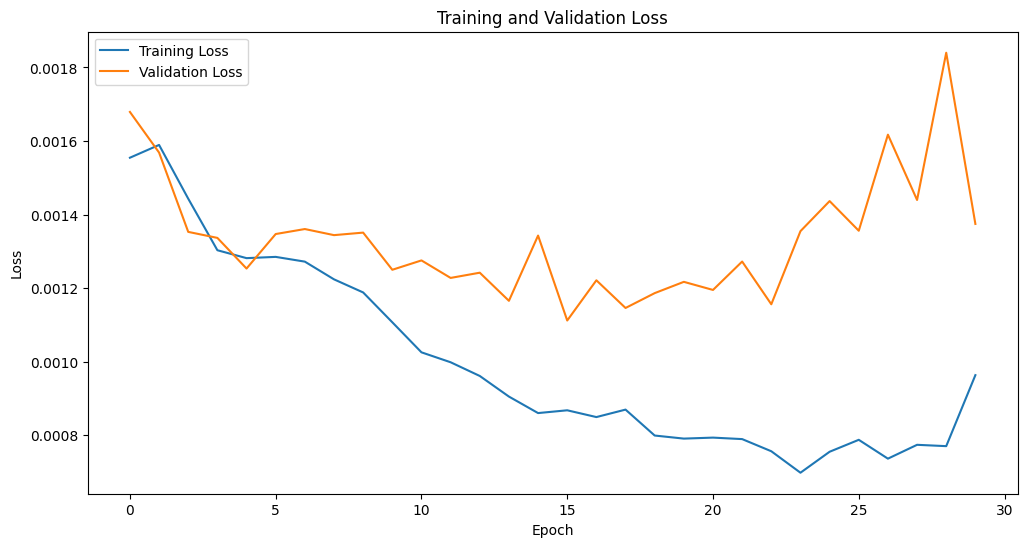

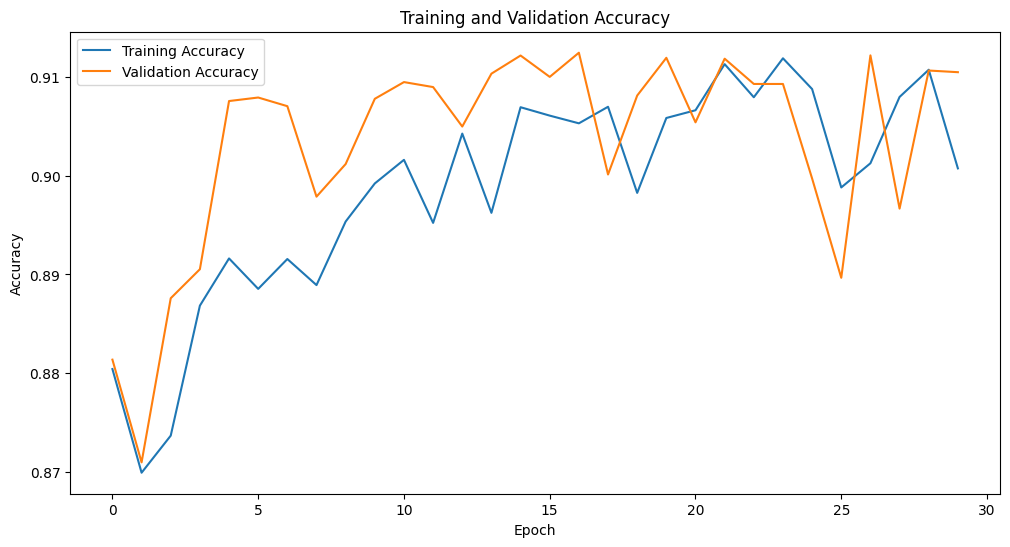

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive
Model saved to /content/drive/My Drive/CAS Advanced Machine Learning/Luftbild_Colorization/model


In [ ]:
# Define the path where you want to save your model on Google Drive
model_save_path = '/content/drive/My Drive/CAS Advanced Machine Learning/Luftbild_Colorization/Retrained_Hyper_U_Net.h5'

# Convert the SavedModel to HDF5 format and save it as an HDF5 file
loaded_model.save(model_save_path, save_format='h5')

print(f"Model saved as HDF5 file to {model_save_path}")

Model saved as HDF5 file to /content/drive/My Drive/CAS Advanced Machine Learning/Luftbild_Colorization/Retrained_Hyper_U_Net.h5
